In [36]:
import os
import sys
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib_venn import venn2, venn3

In [37]:
sys.path.append("/cellar/users/aklie/data/datasets/tf_perturb_seq/config")
from loader import load_colors

In [38]:
dataset_colors = load_colors("technology-benchmark_WTC11_TF-Perturb-seq", "dataset_colors")
dataset_order = load_colors("technology-benchmark_WTC11_TF-Perturb-seq", "dataset_order")

# Get all significant guide hits

In [39]:
files = glob.glob("/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/*/results/2_qc/2025_12_01/inference_qc/*_perturbo-cis-intended-target_significant-pval-0.05.tsv")
files

['/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3/results/2_qc/2025_12_01/inference_qc/Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3_perturbo-cis-intended-target_significant-pval-0.05.tsv',
 '/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Huangfu_WTC11-benchmark_TF-Perturb-seq/results/2_qc/2025_12_01/inference_qc/Huangfu_WTC11-benchmark_TF-Perturb-seq_perturbo-cis-intended-target_significant-pval-0.05.tsv',
 '/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Hon_WTC11-benchmark_TF-Perturb-seq/results/2_qc/2025_12_01/inference_qc/Hon_WTC11-benchmark_TF-Perturb-seq_perturbo-cis-intended-target_significant-pval-0.05.tsv',
 '/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Gersbach_WTC11-benchmark_TF-Perturb-seq_HTv2/results/2_qc/2025_12_01/inference_qc/Gersbach_WTC11-benchmark_TF-Perturb-seq_HTv2_perturbo-cis-intended-target_significant-pval-0.05.tsv']

In [40]:
# Load in and concatenate all res
all_res = []
for f in files:
    df = pd.read_csv(f, sep="\t")
    all_res.append(df)
    df["dataset"] = f.split("/")[-6]
all_res_df = pd.concat(all_res)
all_res_df["lab"] = all_res_df["dataset"].replace("_WTC11-benchmark_TF-Perturb-seq", "", regex=True)
all_res_df.head()

,guide_id,gene_name,log2_fc,p_value,dataset,lab
0,CD81#weak,CD81,-2.034811,0.000000e+00,Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3,Gersbach_GEM-Xv3
1,CD151#strong,CD151,-1.922338,4.578427e-208,Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3,Gersbach_GEM-Xv3
2,CD151#weak,CD151,-1.365486,1.335429e-271,Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3,Gersbach_GEM-Xv3
3,CD55#strong,CD55,-1.929456,5.159432e-64,Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3,Gersbach_GEM-Xv3
4,NGFRAP1#B,NGFRAP1,-1.898682,0.000000e+00,Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3,Gersbach_GEM-Xv3


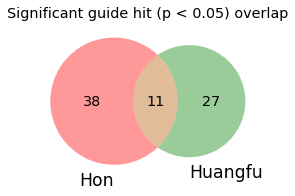

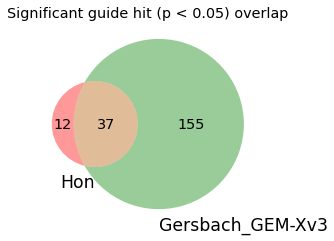

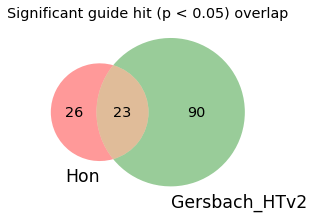

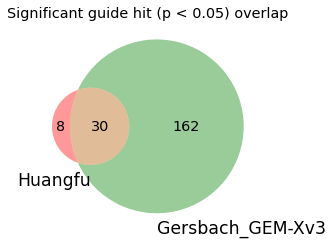

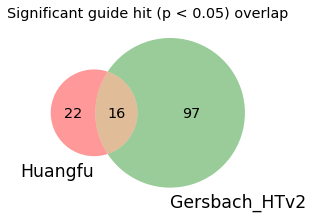

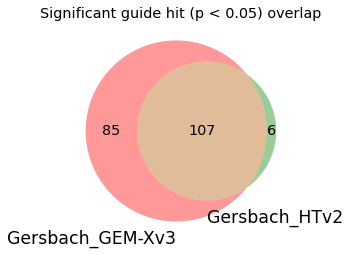

In [41]:
# Plot venn diagram of significant guide hits per dataset pair
with sns.plotting_context("notebook", font_scale=1.2):
    for i, dataset1 in enumerate(dataset_order):
        for j, dataset2 in enumerate(dataset_order):
            if i >= j:
                continue
            df1 = all_res_df[all_res_df["dataset"] == dataset1]
            df2 = all_res_df[all_res_df["dataset"] == dataset2]
            if df1.shape[0] == 0 or df2.shape[0] == 0:
                continue
            guides1 = set(df1["guide_id"].unique())
            guides2 = set(df2["guide_id"].unique())
            plt.figure(figsize=(4,4))
            lab1 = dataset1.replace("_WTC11-benchmark_TF-Perturb-seq", "")
            lab2 = dataset2.replace("_WTC11-benchmark_TF-Perturb-seq", "")
            venn2([guides1, guides2], set_labels=(lab1, lab2))
            plt.title("Significant guide hit (p < 0.05) overlap")
            plt.show()

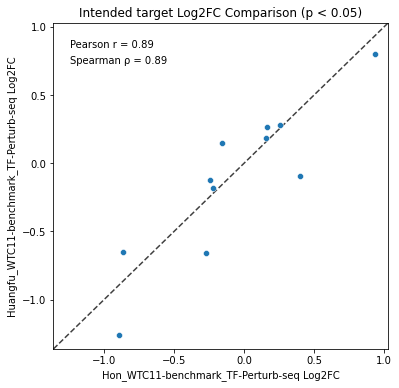

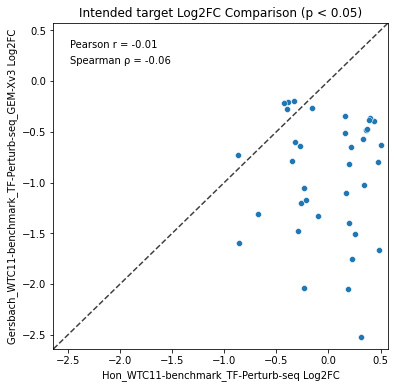

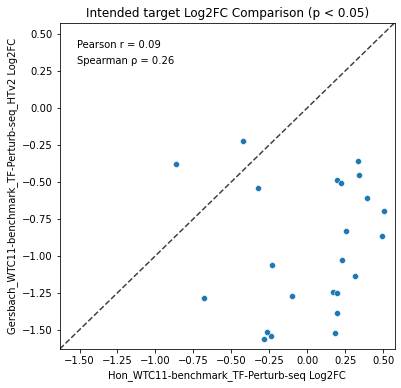

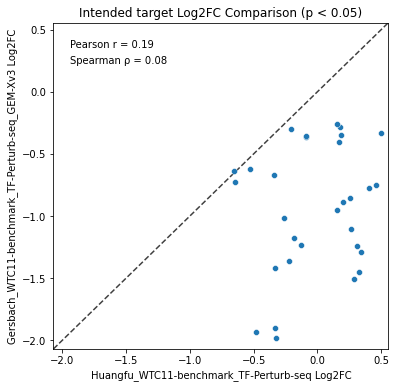

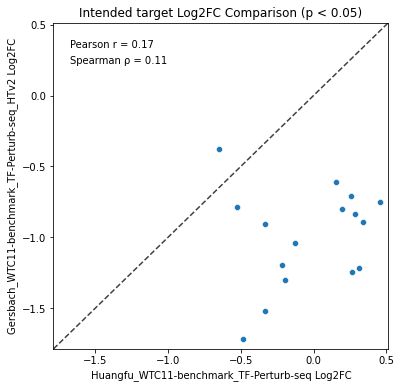

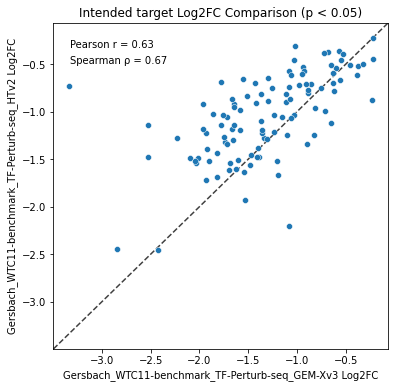

In [42]:
# Scatterplot of log2FC for each pair of datasets
for i, dataset1 in enumerate(dataset_order):
    for j, dataset2 in enumerate(dataset_order):
        if i >= j:
            continue
        df1 = all_res_df[all_res_df["dataset"] == dataset1]
        df2 = all_res_df[all_res_df["dataset"] == dataset2]
        merged = pd.merge(df1, df2, on="guide_id", suffixes=(f"_{dataset1}", f"_{dataset2}"))
        if merged.empty:
            continue
        plt.figure(figsize=(6, 6))
        sns.scatterplot(data=merged, x=f"log2_fc_{dataset1}", y=f"log2_fc_{dataset2}")
        plt.title(f"Intended target Log2FC Comparison (p < 0.05)")
        plt.xlabel(f"{dataset1} Log2FC")
        plt.ylabel(f"{dataset2} Log2FC")
        plt.grid(False)

        # Add diagonal line
        lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
        plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
        plt.xlim(lims)
        plt.ylim(lims)

        # Add correlation coefficients: pearson and spearman
        corr = np.corrcoef(merged[f"log2_fc_{dataset1}"], merged[f"log2_fc_{dataset2}"])[0, 1]
        plt.text(0.05, 0.95, f"Pearson r = {corr:.2f}", transform=plt.gca().transAxes,
                 verticalalignment='top')
        spearman_corr = merged[[f"log2_fc_{dataset1}", f"log2_fc_{dataset2}"]].corr(method='spearman').iloc[0, 1]
        plt.text(0.05, 0.90, f"Spearman ρ = {spearman_corr:.2f}", transform=plt.gca().transAxes,
                 verticalalignment='top')
        plt.show()

# DONE!

---